# Построение нейронной сети средствами TF

Используя набор данных об автомобилях, а также фреймворк TensorFlow, постройте модель, решающую задачу предсказания экономичности автомобиля (MPG). Для оценки полученной модели используйте метрику MAE. Самостоятельно выполните предварительную обработку (например, заполнение или удаление пропусков) и разбиение датасета на тренировочную и тестовую части. В качестве архитектуры используйте полносвязную нейронную сеть с максимум тремя скрытыми слоями. Самостоятельно произведите подбор оптимальных гиперпараметров. 



In [102]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

Загрузка данных. 

Целевая переменная -- MPG. 

Метрика для оценки модели -- MAE.

In [103]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)
raw_dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


In [104]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


In [105]:
#raw_dataset.duplicated()
duplicateRows = raw_dataset[raw_dataset.duplicated ()]
print(duplicateRows)

Empty DataFrame
Columns: [MPG, Cylinders, Displacement, Horsepower, Weight, Acceleration, Model Year, Origin]
Index: []


In [106]:
dataset = raw_dataset.dropna().drop(['Origin'], axis=1)
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year
0,18.0,8,307.0,130.0,3504.0,12.0,70
1,15.0,8,350.0,165.0,3693.0,11.5,70
2,18.0,8,318.0,150.0,3436.0,11.0,70
3,16.0,8,304.0,150.0,3433.0,12.0,70
4,17.0,8,302.0,140.0,3449.0,10.5,70
...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82
394,44.0,4,97.0,52.0,2130.0,24.6,82
395,32.0,4,135.0,84.0,2295.0,11.6,82
396,28.0,4,120.0,79.0,2625.0,18.6,82


In [107]:
# создаем тензоры-константы на основе обучающей выборки
X = dataset.drop(['MPG'], axis=1)
y = dataset['MPG']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year
260,6,225.0,110.0,3620.0,18.7,78
184,4,140.0,92.0,2572.0,14.9,76
174,6,171.0,97.0,2984.0,14.5,75
64,8,318.0,150.0,4135.0,13.5,72
344,4,86.0,64.0,1875.0,16.4,81
...,...,...,...,...,...,...
72,8,304.0,150.0,3892.0,12.5,72
107,6,232.0,100.0,2789.0,15.0,73
272,4,151.0,85.0,2855.0,17.6,78
352,4,98.0,65.0,2380.0,20.7,81


In [108]:
X_train.shape

(313, 6)

In [109]:
X_test.shape

(79, 6)

In [110]:
y_train.shape

(313,)

In [111]:
y_test.shape

(79,)

Стандартизируем признаки и создадим константы для TensorFlow

In [112]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = tf.constant(scaler.fit_transform(X_train), dtype=tf.float32) 
X_test_scaled = tf.constant(scaler.transform(X_test), dtype=tf.float32) 
y_train = tf.constant(y_train, dtype=tf.float32, shape=(len(X_train), 1))
y_test = tf.constant(y_test, dtype=tf.float32)

Будем использовать полносвязную сеть с тремя скрытыми слоями. Определим количество нейронов в каждом слое.

In [113]:
num_input = 6  # количество входных нейронов — 6 признаков
num_hidden1 = 64  # количество нейронов первого скрытого слоя
num_hidden2 = 64  # количество нейронов второго скрытого слоя
num_hidden3 = 64 # количество нейронов третьего скрытого слоя
num_output = 1  # количество выходов. Для регрессии это 1 выход

In [114]:
# Сформируем архитектурунашей сети
def regression_auto(x):
    # создаем первый скрытый слой со своими весами и сдвигами, используем ReLU в качестве функции активации
    hidden_layer1 = tf.add(tf.matmul(x, weights['w_h1']), biases['b_h1'])
    hidden_layer1 = tf.nn.relu(hidden_layer1)
    # создаем второй скрытый слой со своими весами и сдвигами, используем ReLU в качестве функции активации
    hidden_layer2 = tf.add(tf.matmul(hidden_layer1, weights['w_h2']), biases['b_h2'])
    hidden_layer2 = tf.nn.relu(hidden_layer2)
    # создаем третий скрытый слой со своими весами и сдвигами, используем ReLU в качестве функции активации
    hidden_layer3 = tf.add(tf.matmul(hidden_layer2, weights['w_h3']), biases['b_h3'])
    hidden_layer3 = tf.nn.relu(hidden_layer3)
    # создаем последний слой. Так как мы решаем задачу регрессии, то функция активации — линейная
    out_layer = tf.add(tf.matmul(hidden_layer3, weights['w_out']), biases['b_out'])
    return out_layer

In [115]:
# случайным образом инициализируем веса и сдвиги соответствующих размеров
weights = {
    'w_h1': tf.Variable(tf.random.uniform([num_input, num_hidden1])),
    'w_h2': tf.Variable(tf.random.uniform([num_hidden1, num_hidden2])),
    'w_h3': tf.Variable(tf.random.uniform([num_hidden2, num_hidden3])),
    'w_out': tf.Variable(tf.random.uniform([num_hidden3, num_output]))
}
biases = {
    'b_h1': tf.Variable(tf.random.uniform([num_hidden1])),
    'b_h2': tf.Variable(tf.random.uniform([num_hidden2])),
    'b_h3': tf.Variable(tf.random.uniform([num_hidden3])),
    'b_out': tf.Variable(tf.random.uniform([num_output]))
}

In [116]:
# Теперь зададим проход вперед по подаваемому набору данных
def forward_pass(x):
    return regression_auto(x)

In [117]:
#задаем функцию потерь МАЕ
def loss():
    return tf.reduce_mean(tf.abs(y_batch - forward_pass(X_batch)))

In [118]:
optimizer = tf.optimizers.Adam(0.01, clipnorm=1)

In [119]:
# Теперь можно приступить к обучению

# Количество эпох
ep_number = 100
# Как часто показывать лосс во время обучения
display_step = 10

history = []

for ep in range(ep_number):
    X_batch = X_train_scaled
    y_batch = y_train
    optimizer.minimize(loss, [weights, biases])
    history.append(np.array([ep, loss().numpy()]))
    if ep % display_step == 0:
      print('Epoch: ' + str(ep + 1) + ' Loss: ' + str(loss()))

Epoch: 1 Loss: tf.Tensor(25332.146, shape=(), dtype=float32)
Epoch: 11 Loss: tf.Tensor(9762.253, shape=(), dtype=float32)
Epoch: 21 Loss: tf.Tensor(2611.8135, shape=(), dtype=float32)
Epoch: 31 Loss: tf.Tensor(41.887352, shape=(), dtype=float32)
Epoch: 41 Loss: tf.Tensor(122.588455, shape=(), dtype=float32)
Epoch: 51 Loss: tf.Tensor(14.950163, shape=(), dtype=float32)
Epoch: 61 Loss: tf.Tensor(7.073659, shape=(), dtype=float32)
Epoch: 71 Loss: tf.Tensor(5.141761, shape=(), dtype=float32)
Epoch: 81 Loss: tf.Tensor(4.6927695, shape=(), dtype=float32)
Epoch: 91 Loss: tf.Tensor(3.7594352, shape=(), dtype=float32)


In [120]:
# Теперь зададим проход вперед по подаваемому набору данных.

def forward_pass(x):
    return regression_auto(x)

In [121]:
# Зададим функцию потерь. Так как в качестве метрики у нас выступает MAE, эту функцию и будем минимизировать.

def loss():
    return tf.reduce_mean(tf.abs(y_batch - forward_pass(X_batch)))
# В качестве оптимизатора будем использовать Adam

optimizer = tf.optimizers.Adam(0.01, clipnorm=1)


In [122]:
# Количество эпох
ep_number = 100
# Как часто показывать лосс во время обучения
display_step = 10

history = []


for ep in range(ep_number):
    X_batch = X_train_scaled
    y_batch = y_train
    optimizer.minimize(loss, [weights, biases])
    history.append(np.array([ep, loss().numpy()]))
    if ep % display_step == 0:
      print('Epoch: ' + str(ep + 1) + ' Loss: ' + str(loss()))


Epoch: 1 Loss: tf.Tensor(6.6793437, shape=(), dtype=float32)
Epoch: 11 Loss: tf.Tensor(2.348484, shape=(), dtype=float32)
Epoch: 21 Loss: tf.Tensor(2.101305, shape=(), dtype=float32)
Epoch: 31 Loss: tf.Tensor(2.1448162, shape=(), dtype=float32)
Epoch: 41 Loss: tf.Tensor(1.7140616, shape=(), dtype=float32)
Epoch: 51 Loss: tf.Tensor(1.7643325, shape=(), dtype=float32)
Epoch: 61 Loss: tf.Tensor(1.8319217, shape=(), dtype=float32)
Epoch: 71 Loss: tf.Tensor(1.560724, shape=(), dtype=float32)
Epoch: 81 Loss: tf.Tensor(1.7155856, shape=(), dtype=float32)
Epoch: 91 Loss: tf.Tensor(1.7746198, shape=(), dtype=float32)


In [123]:
# Оценим модель на тестовых данных

results = forward_pass(X_test_scaled)
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, results)

1.7238669

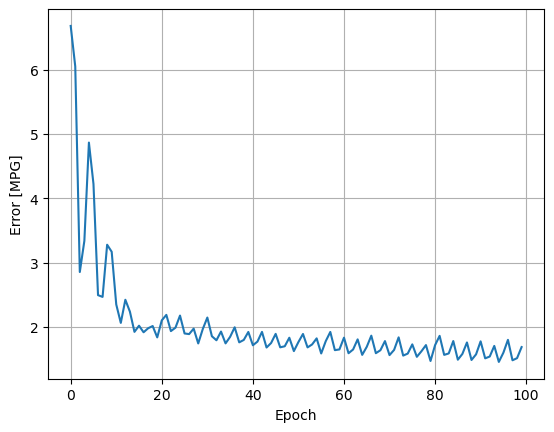

In [124]:
# Посмотрим на график уменьшения функции потерь. Останавливаться можно было сильно заранее

def plot_loss(history):
  x = np.array(history)[:,0]
  y = np.array(history)[:,1]
  plt.plot(x,y)
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.grid(True)

plot_loss(history)

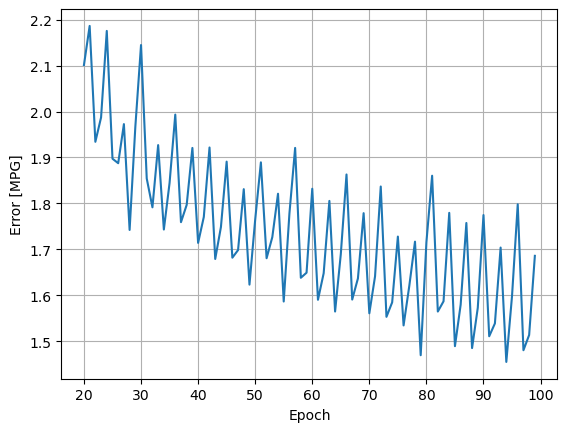

In [125]:
# Можно увидеть изменение ошибки и более детально.

plot_loss(history[20:])